# Best Machine Learning Architecture
----

<h4> Description </h4>
Here I want to anwser the question, what is the best machine learning architecture to estimate stellar masses? For instance, previously I saw that Random Forest is not a good algorithm for extrapolating the data for massive galaxies.


In [1]:
import numpy as np
import astropy.io.ascii as at
import scipy.stats as st
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

## Load Cosmos Sample

In [2]:
path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
fname = path+'desCosmosML_sample.fits'
joined = Table(getdata(fname))

In [3]:
### get machine learning selection

In [4]:
def transform_to_1d(x,y):
    ynew = y[:,0]
    xnew = np.vstack([x.T,y[:,1]]).T
    return xnew, ynew

In [5]:
path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
x_train = np.load(path+'qf_x_train.npy')
y_train = np.load(path+'qf_y_train.npy')

x_test = np.load(path+'qf_x_test.npy')
y_test = np.load(path+'qf_y_test.npy')

y_train_err = np.array(joined['smass_err'][joined['Train']])

In [6]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [7]:
x_train_small = x_train1d[:,4:]
x_test_small = x_test1d[:,4:]

## Cross Validation Sample

In [8]:
import sys

sys.path.append('/data/des81.a/data/jesteves/GitHub/galpro')
from galpro import model
from galpro.convert_mag_to_lupmag import get_input_galpro

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [23]:
## load target data
fname = '../data/des_sdssGalexWISE_matched.csv'
data = at.read(fname)

mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mask= data['sdss_mass']>0.
ztrue= data['sdss_z']

x_target = get_input_galpro(mags[mask],ztrue[mask])

from astropy.cosmology import WMAP9 as cosmo

distMod = cosmo.distmod(ztrue[mask]).value
absMags = x_target[:,:4]-distMod[:,np.newaxis]
x_target1d = np.c_[x_target,absMags[:,2]]

y_target = np.array(data['sdss_mass'][mask])
x_target_small = x_target1d[:,4:]

## Training with ML Architectures

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
import time

# from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

## all default params
ann_pipeline = make_pipeline(MLPRegressor())
rf_pipeline = make_pipeline(RandomForestRegressor())
gradient_pipeline = make_pipeline(GradientBoostingRegressor())
svm_pipeline = make_pipeline(SVR())

estimators = [('ANN', ann_pipeline),
              ('Random Forest', rf_pipeline),
              ('Gradient Boosting', gradient_pipeline),
              ('SVM', svm_pipeline)]

In [14]:
idx = np.random.randint(len(y_train1d), size=10000)
x = x_train_small[idx,:]
y = y_train1d[idx]

In [15]:
def header(name):
    print(5*'-----')
    print('Machine Learning Training: %s'%name)

def fit(self,x,y):
    start_time = time.time()
    self.fit(x,y)
    self.elapsed_time = (time.time()-start_time)/60.
    print('Elapsed time: %.2f min'%self.elapsed_time)
    
for (name, estimator) in estimators:
    header(name)
    fit(estimator,x,y)
    print('')

-------------------------
Machine Learning Training: ANN
Elapsed time: 0.01 min

-------------------------
Machine Learning Training: Random Forest
Elapsed time: 0.01 min

-------------------------
Machine Learning Training: Gradient Boosting
Elapsed time: 0.01 min

-------------------------
Machine Learning Training: SVM
Elapsed time: 0.03 min



In [22]:
x_target_small.shape

(32218, 4)

In [24]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.1,s=5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left',fontsize=12)
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)
    
def median_abs_deviation(x,scale=1.0):
    return np.median(np.abs(x-np.median(x)))/scale

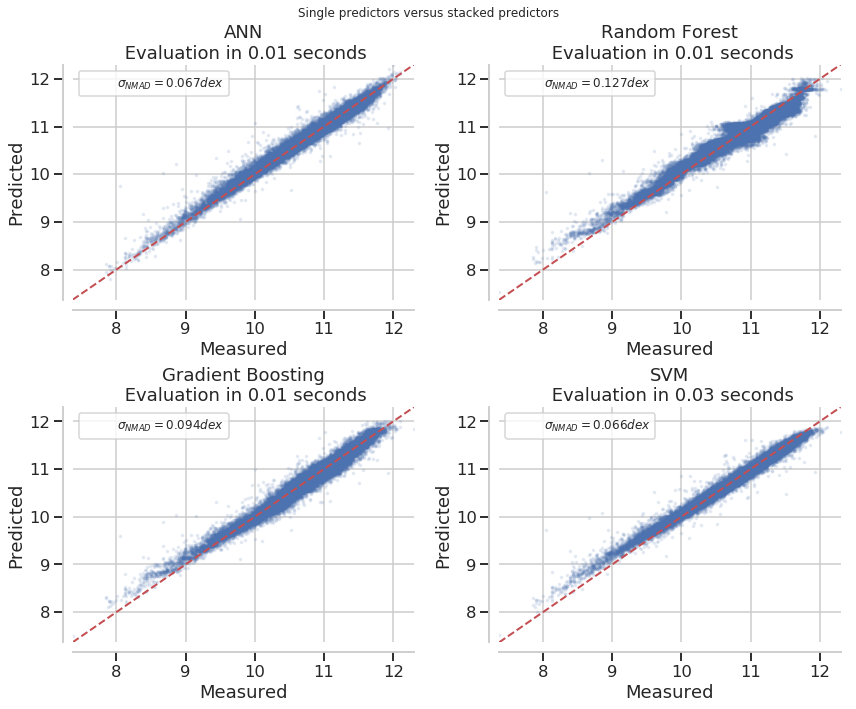

In [28]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_target_pred = est.predict(x_target_small)
    snmad = median_abs_deviation(y_target-y_target_pred,scale=1/1.4826)
    offset = np.median(y_target-y_target_pred)
    plot_regression_results(
        ax, y_target, y_target_pred+offset,
        name, r'$\sigma_{NMAD} = %.3f dex$'%(snmad),
        elapsed_time)
plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

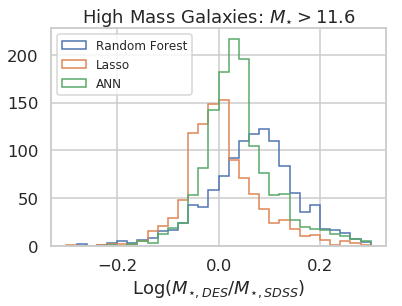

In [164]:
# xhigh = y_target>11.6
for name, est in estimators:
    ypred = est.predict(x_target1d)
    res = ypred-y_target
    yhigh = (ypred-np.median(res))>11.6
    plt.hist((res-np.median(res))[yhigh], bins=np.linspace(-0.3,0.3,31),histtype='step',label=name)
    plt.title('High Mass Galaxies: $M_{\star}>11.6$')
plt.xlabel('Log($M_{\star,DES}/M_{\star,SDSS}$)')
plt.legend(fontsize=12,loc=2)

### Red and Dead Selection

In [33]:
ssfr = np.array(joined['sSFR'])
smassA = np.array(joined['smass'])

Text(0.5,1,'Red and Blue')

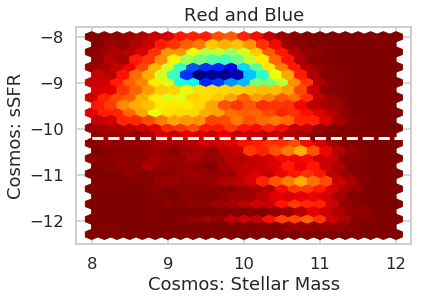

In [35]:
plt.hexbin(smassA,ssfr,extent=[8,12,-12.3,-8],gridsize=24,cmap='jet_r')
plt.axhline(-10.2,color='w',ls='--',lw=3)
plt.xlabel('Cosmos: Stellar Mass')
plt.ylabel('Cosmos: sSFR')
plt.title('Red and Blue')

In [92]:
# select high mass galaxies
high10k = np.argsort(-1*y_train[:,0])
redDead = high10k[(y_train[high10k,2]==1)&(x_train[high10k,-1]<=1.5)&(x_train[high10k,-1]>=0.13)][:10000]

smass = y_train[redDead,0]
Mi = y_train[redDead,1]
qf = y_train[redDead,2]
z = x_train[redDead,-1]

# some other abs mags
Mz = joined['MZ'][redDead]
Mr = joined['MR'][redDead]

Text(0.5,1,'10k Most Massive Red Galaxies')

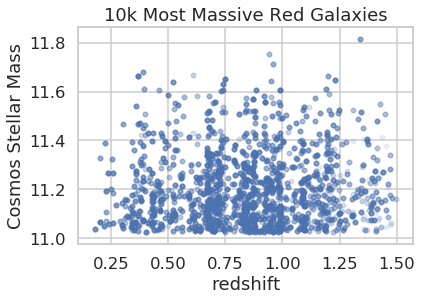

In [93]:
plt.scatter(z,smass,s=20,alpha=0.1)
plt.xlabel('redshift')
plt.ylabel('Cosmos Stellar Mass')
plt.title('10k Most Massive Red Galaxies')

Text(0.5,1,'10k Most Massive Red Galaxies')

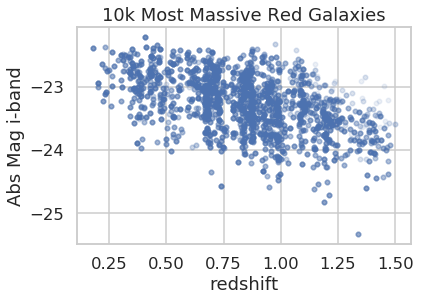

In [94]:
plt.scatter(z,Mi,s=20,alpha=0.1)
plt.xlabel('redshift')
plt.ylabel('Abs Mag i-band')
plt.title('10k Most Massive Red Galaxies')

## Model Scaling Relation

I will assume that brightness correlates linearly with the stellar mass.

In [95]:
xlabel = r'M$_{z}$'
ylabel = r'Log(M$_{\star}/M_{\odot}$)'

Text(0.5,1,'Scaling Relation')

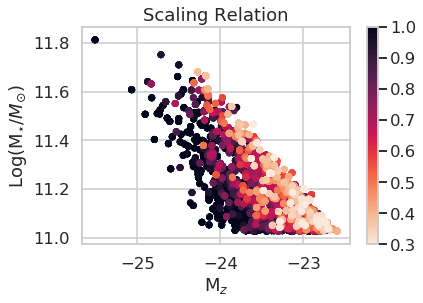

In [96]:
ix = np.argsort(-1*z)
plt.scatter(Mz[ix],smass[ix],c=z[ix],s=30,alpha=0.9,vmin=0.3,vmax=1.,cmap='rocket_r')
plt.colorbar()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Scaling Relation')

There correlation between stellar mass and Mi is tight for low redshift and get broader at high redshift. The broadening reflects the fact the i-band after 0.65 loses flux due to the 4000 $\rm \mathring A$ break. <br>

This evolutionary trend makes me think If would be better to define in terms of a not band, for instance z-band.

## Modeling the Slope/Width

In [97]:
def make_bins(x,xbins):
    indices = []
    xmd     = 0.5*(xbins[1:]+xbins[:-1])
    for xl,xh in zip(xbins[:-1],xbins[1:]):
        w, = np.where((x<=xh)&(x>xl))
        indices.append(w)
    return indices,xmd

In [98]:
zbins = np.arange(np.min(z),1.1+0.1,0.2)
zbins = np.append(zbins, np.percentile(z[z>zbins[-1]], np.linspace(20,100,4)))
# zbins[1] = 0.35
# zbins = np.percentile(z, np.linspace(0,100,21))
zkeys, zmed = make_bins(z, zbins)
zbins

array([0.18000001, 0.38000001, 0.58000001, 0.78000001, 0.98000001,
       1.18000001, 1.19889998, 1.24689996, 1.36283335, 1.49800003])

In [99]:
def compute_res(x,y,coefs):
    ytrue = np.poly1d(coefs)(x)
    res = (y - ytrue)
    return np.std(res)

In [100]:
scaling = dict()
bandNames = ['Mr','Mi','Mz']
bands = [Mr, Mi, Mz]
for i, band, col in zip(range(3),bands,bandNames):
    model = np.zeros((4,len(zmed)))
    model[0] = zmed
    for i,ix in enumerate(zkeys):
        x, y = (band[ix]+21.)/21., smass[ix]
        coefs = list(np.polyfit(x, y, 1))
        coefs+= [compute_res(x,y,coefs)]
        model[1:,i] = coefs
    
    scaling[col] = model

In [101]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Category10, RdBu, Reds

colors = np.flip(Reds[4][:3],0)

Text(0.5,1,'Intercept')

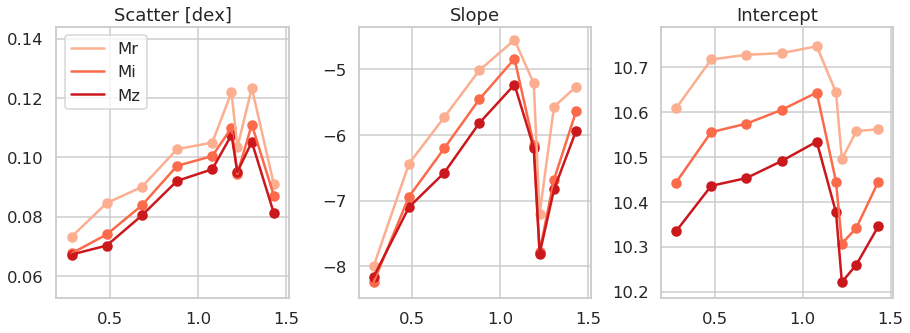

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharex='all')
fig.subplots_adjust(wspace=0.3)

for color, label in zip(colors,bandNames):
    model = scaling[label]
    axs[0].scatter(model[0],model[3],color=color)
    axs[1].scatter(model[0],model[1],color=color)
    axs[2].scatter(model[0],model[2],color=color)

    axs[0].plot(model[0],model[3],label=label,color=color)
    axs[1].plot(model[0],model[1],label=label,color=color)
    axs[2].plot(model[0],model[2],label=label,color=color)

axs[0].legend()
axs[0].set_title('Scatter [dex]')
axs[1].set_title('Slope')
axs[2].set_title('Intercept')

The best band would be z. There is a weird behaviour at the lowest redshift bin.

Text(0.5,1,'Scaling Relation')

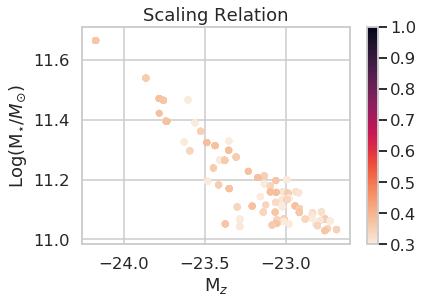

In [103]:
# ix = np.argsort(-1*z)
ix = zkeys[0]
plt.scatter(Mz[ix],smass[ix],c=z[ix],s=30,alpha=0.9,vmin=0.3,vmax=1.,cmap='rocket_r')
plt.colorbar()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Scaling Relation')

In [104]:
zbins

array([0.18000001, 0.38000001, 0.58000001, 0.78000001, 0.98000001,
       1.18000001, 1.19889998, 1.24689996, 1.36283335, 1.49800003])